In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
import altair as alt
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from matplotlib import pyplot
from sklearn.feature_selection import RFE
import statsmodels.api as sm

# 1. Overview

## 1.1 Loading Data

In [2]:
df = pd.read_csv("/Users/juliachen/Desktop/DSCI552/hw/hw2/ps2_available_dataset.csv") 
df.head()

,treatment,age,blood_pressure,gender,blood_test,family_history,MeasureA,TestB,GeneA,GeneB,GeneC
0,1,74,94.113373,non-female,negative,False,-11.035690,-0.336843,double,1,0
1,1,56,83.337745,non-female,negative,False,-3.982345,-0.018734,none,1,1
2,0,37,81.759240,female,negative,False,6.205701,0.147933,double,1,1
3,1,54,88.549518,female,negative,False,-1.827613,-0.338373,none,1,1
4,0,73,82.171555,female,negative,NaN,-14.637389,-0.369325,none,1,1


treatment: yes - 1, no - 0

## 1.2 Check the data

In [3]:
# get the dimension for dataset
df.shape

(10000, 11)

In [4]:
# description of the each attribute
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   treatment       10000 non-null  int64  
 1   age             10000 non-null  int64  
 2   blood_pressure  10000 non-null  float64
 3   gender          10000 non-null  object 
 4   blood_test      10000 non-null  object 
 5   family_history  7068 non-null   object 
 6   MeasureA        10000 non-null  float64
 7   TestB           10000 non-null  float64
 8   GeneA           10000 non-null  object 
 9   GeneB           10000 non-null  int64  
 10  GeneC           10000 non-null  int64  
dtypes: float64(3), int64(4), object(4)
memory usage: 859.5+ KB


* There are 11 variables, the treatment variable is the dependent variable where the result is binary, so 0 represents people has no treatment and 1 represents people has treatment, and other 10 are the independent variables.

* Among those independent variables, there are 6 numeric features and 4 categorical features.

In [5]:
# Summary of each numerical attribute
df.describe()

,treatment,age,blood_pressure,MeasureA,TestB,GeneB,GeneC
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.358700,60.032800,84.642355,-5.992414,0.004466,0.547900,0.550400
std,0.479643,8.106546,5.266045,4.168837,0.322338,0.497725,0.497478
min,0.000000,29.000000,-99.000000,-21.708000,-0.564197,0.000000,0.000000
25%,0.000000,55.000000,82.314030,-8.790691,-0.251337,0.000000,0.000000
50%,0.000000,60.000000,83.997305,-5.956422,-0.039662,1.000000,1.000000
75%,1.000000,66.000000,86.342954,-3.217110,0.215928,1.000000,1.000000
max,1.000000,92.000000,107.595583,8.889658,1.231447,1.000000,1.000000


treatment, GeneB, GeneC are binary variables, while age, blood pressure, MeasureA and TestB are continues variables.

In [6]:
# Summary for continues variables
df[['age','blood_pressure','MeasureA','TestB']].describe()

,age,blood_pressure,MeasureA,TestB
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,60.032800,84.642355,-5.992414,0.004466
std,8.106546,5.266045,4.168837,0.322338
min,29.000000,-99.000000,-21.708000,-0.564197
25%,55.000000,82.314030,-8.790691,-0.251337
50%,60.000000,83.997305,-5.956422,-0.039662
75%,66.000000,86.342954,-3.217110,0.215928
max,92.000000,107.595583,8.889658,1.231447


In [7]:
# level of each categorical attribute
print(df["gender"].unique())
print(df["blood_test"].unique())
print(df["family_history"].unique())
print(df["GeneA"].unique()) 

['non-female' 'female']
['negative' 'positive']
[False nan True]
['double' 'none' 'single']


In [8]:
# count of each level for categorical attribute
print(df["gender"].value_counts())
print(df["blood_test"].value_counts())
print(df["family_history"].value_counts())
print(df["GeneA"].value_counts()) 

female        6362
non-female    3638
Name: gender, dtype: int64
negative    9067
positive     933
Name: blood_test, dtype: int64
False    6968
True      100
Name: family_history, dtype: int64
none      4482
double    3479
single    2039
Name: GeneA, dtype: int64


## 1.3 Check missing data

In [9]:
# missing variable
total = df.isnull().sum().sort_values(ascending = False)
pd.concat([total], axis=1, keys=['Total Missing']).transpose()

,family_history,GeneC,GeneB,GeneA,TestB,MeasureA,blood_test,gender,blood_pressure,age,treatment
Total Missing,2932,0,0,0,0,0,0,0,0,0,0


There are 2932 missing variable in family history variable. I fill the family_history using by replacing those missing famaily history as the True, preventing from heavy imbalance 

In [10]:
# fill missing family_history 
df["family_history"] = df["family_history"].fillna(True)

# fill missing record as True response, and divided the it into 'false response' and 'others response'
df['family_history']=df['family_history'].replace(True,'others response') 
df['family_history']=df['family_history'].replace(False,'false response') 

print(df["family_history"].value_counts())

false response     6968
others response    3032
Name: family_history, dtype: int64


## 1.4 Check data imbalance on response variable

In [11]:
#check treatment by number
df["treatment"].value_counts()

0    6413
1    3587
Name: treatment, dtype: int64

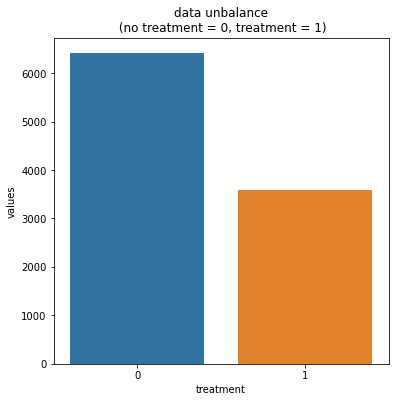

In [12]:
#check treatment by visualization 
treatment = df["treatment"].value_counts()
dftreatment = pd.DataFrame({'treatment': treatment.index,'values': treatment.values})
plt.figure(figsize = (6,6))
plt.title('data unbalance\n (no treatment = 0, treatment = 1)')
sns.set_color_codes("pastel")
sns.barplot(x = 'treatment', y="values", data=dftreatment)
locs, labels = plt.xticks()
plt.show()

We can see that more no treatment than treatment group, so the dataset is imbalanced, but we can weight the classes by their representation in the data to reflect this imbalance later.

# 2. Data Exploration

## 2.1 Label encoding

Female and non femele (gender), negative and positive(blood_test), true and false (family_history) are binary variable, so make ordinal encoding for those variables. 

### Ordinal encoding for "gender", "blood_test" , "GeneA" and "family_history"

In [13]:
# define LabelEncoder
le = preprocessing.LabelEncoder()
# encoding for gener, blood test and GeneA
df[["gender","blood_test","GeneA"]] = df[["gender","blood_test","GeneA"]].apply(le.fit_transform)

In [14]:
# encoding for family history
df['family_history'] = le.fit_transform(df['family_history'].astype(str))
df

,treatment,age,blood_pressure,gender,blood_test,family_history,MeasureA,TestB,GeneA,GeneB,GeneC
0,1,74,94.113373,1,0,0,-11.035690,-0.336843,0,1,0
1,1,56,83.337745,1,0,0,-3.982345,-0.018734,1,1,1
2,0,37,81.759240,0,0,0,6.205701,0.147933,0,1,1
3,1,54,88.549518,0,0,0,-1.827613,-0.338373,1,1,1
4,0,73,82.171555,0,0,1,-14.637389,-0.369325,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...
9995,1,49,89.036800,1,0,0,-1.384107,-0.333167,0,1,0
9996,0,64,90.848126,1,0,1,-6.560963,-0.015892,0,1,0
9997,0,54,82.028043,0,0,0,-3.192784,-0.317267,1,1,0
9998,1,54,82.246645,0,0,0,-4.138708,-0.042504,0,1,1


In [15]:
print(df["gender"].unique())
print(df["blood_test"].unique())
print(df["family_history"].unique())
print(df["GeneA"].unique()) 
print(df["gender"].value_counts())
print(df["blood_test"].value_counts())
print(df["family_history"].value_counts())
print(df["GeneA"].value_counts()) 

[1 0]
[0 1]
[0 1]
[0 1 2]
0    6362
1    3638
Name: gender, dtype: int64
0    9067
1     933
Name: blood_test, dtype: int64
0    6968
1    3032
Name: family_history, dtype: int64
1    4482
0    3479
2    2039
Name: GeneA, dtype: int64


gender:

    0 - female      
    1 - non-female   
    
blood_test:

    0 - negative    
    1 - positive     

family_history:

    0 - false response     
    1 - others response    

GeneA: 
    
    0 - double 
    1 - none         
    2 - single    



In [16]:
# creat dummy variable 
#df_GeneA = pd.get_dummies(df["GeneA"], prefix='GeneA')
#df_family = pd.get_dummies(df["family_history"], prefix='family_history')
# remove the old varible and concat new df
#df = df.drop('family_history',1)
#df = df.drop('GeneA',1)
#df = pd.concat([df ,df_GeneA,df_family], ignore_index=False, axis=1)
#df

## 2.2 Visualization 

Since we have turn every categorical variables into numerical variables, let's see how data distributed now: 

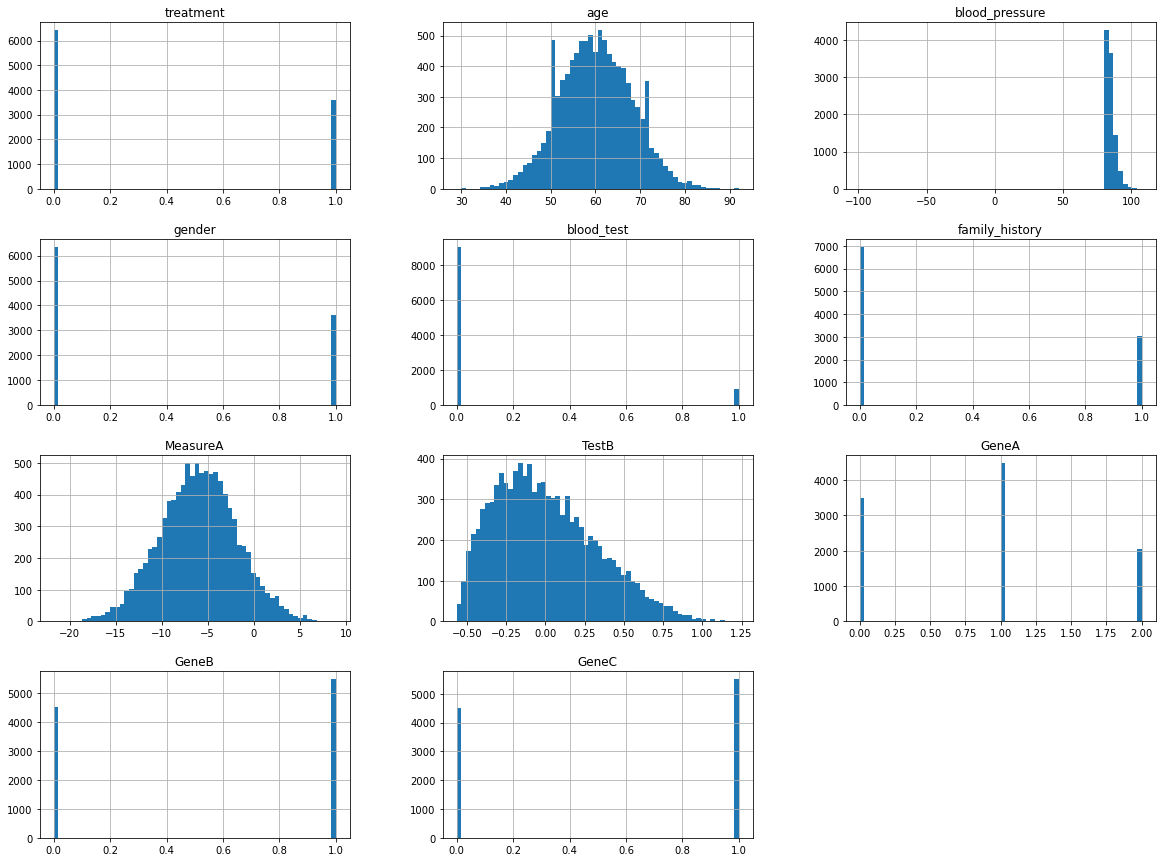

In [17]:
# visualization on numerical attributes, here we have 11 attributes
df.hist(bins=60, figsize=(20,15)) 
plt.show()

From our first visualization on histogram, that treatment, family history and TestB are imbalanced. 
Age, MeasureA are normal distributed. The TestB is right skewed, so the mean is higher than the median. The range for the blood pressure is very small. 

# 2. Exploratory Data Analysis

## 2.1 Split Data Set

In [18]:
y = df['treatment']
X = df.drop('treatment',axis=1)
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

X_train.to_csv("/Users/juliachen/Desktop/DSCI552/hw/hw2/dataset/X_train.csv")
X_test.to_csv("/Users/juliachen/Desktop/DSCI552/hw/hw2/dataset/X_test.csv")
X_val.to_csv("/Users/juliachen/Desktop/DSCI552/hw/hw2/dataset/X_val.csv" )
y_train.to_csv("/Users/juliachen/Desktop/DSCI552/hw/hw2/dataset/y_train.csv")
y_test.to_csv("/Users/juliachen/Desktop/DSCI552/hw/hw2/dataset/y_test.csv")
y_val.to_csv("/Users/juliachen/Desktop/DSCI552/hw/hw2/dataset/y_val.csv")

print("Training y", y_train.shape)
print("Training X", X_train.shape)

print("Testing y", y_test.shape)
print("Testing X", X_test.shape)

print("Validation y", y_val.shape)
print("Validation X", X_val.shape)

Training y (6000,)
Training X (6000, 10)
Testing y (2000,)
Testing X (2000, 10)
Validation y (2000,)
Validation X (2000, 10)


In [19]:
#append train, val and test for convenient
train=pd.concat([y_train ,X_train], ignore_index=False, axis=1)
val=pd.concat([y_val ,X_val], ignore_index=False, axis=1)
test=pd.concat([y_test ,X_test], ignore_index=False, axis=1)

##  2.2  Exploration for age 

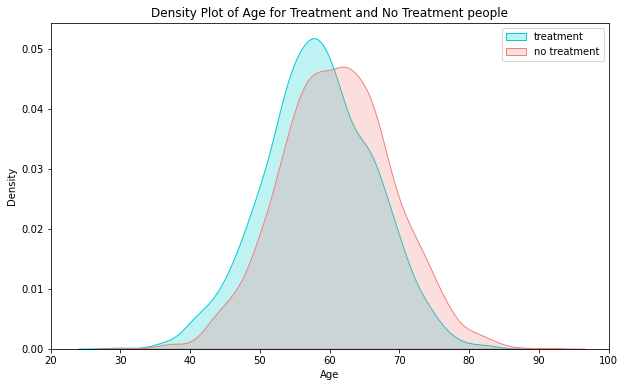

In [20]:
plt.figure(figsize=(10,6))
ax = sns.kdeplot(train["age"][train.treatment == 1], color="darkturquoise", shade=True)
sns.kdeplot(train["age"][train.treatment == 0], color="lightcoral", shade=True)
plt.legend(['treatment', 'no treatment'])
plt.title('Density Plot of Age for Treatment and No Treatment people')
ax.set(xlabel='Age')
plt.xlim(20,100)
plt.show()

## 2.3 Exploration for blood_pressure

In [21]:
print(train['blood_pressure'].describe())

count    6000.000000
mean       84.640726
std         4.697773
min       -99.000000
25%        82.275108
50%        83.967459
75%        86.287308
max       107.595583
Name: blood_pressure, dtype: float64


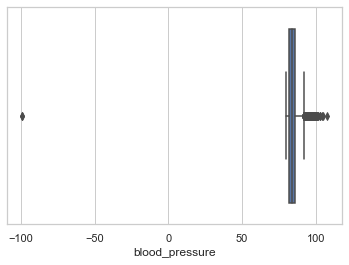

In [22]:
# check outliers on boxplot on train set 
sns.set_theme(style="whitegrid")
ax = sns.boxplot(x=train["blood_pressure"])

From the five summaray statistics, and the boxplot, we can see the lowest value is -99

In [23]:
#check how many blood_pressure <0 on entire dataset
df[df['blood_pressure'] < 0]

,treatment,age,blood_pressure,gender,blood_test,family_history,MeasureA,TestB,GeneA,GeneB,GeneC
379,0,61,-99.0,1,0,1,-6.668494,-0.297216,2,0,0
1104,0,63,-99.0,0,0,1,-6.371654,0.508471,0,0,1
1938,0,62,-99.0,0,1,0,-6.502056,-0.008871,0,0,1
1954,0,60,-99.0,0,0,0,-6.769742,-0.123018,2,0,0
4054,1,46,-99.0,0,0,0,1.085601,0.429901,1,1,1


In [24]:
#keep only blood_pressure>0 
df=df[df['blood_pressure'] > 0]
train=train[train['blood_pressure'] > 0]
val=val[val['blood_pressure'] > 0]
test=test[test['blood_pressure'] > 0]

Noticed that the minimum blood pressure is -99, which does not have a practical meaning. So I will consider -99 as a mistake in inputing. In total, including validation and testing set,there are 5 rows of blood pressure is -99, I will remove those rows in all dataset. 

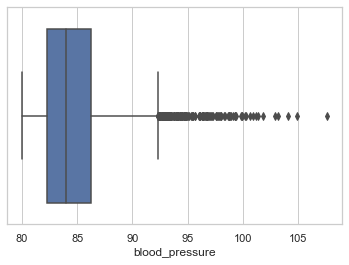

In [25]:
# box plot on blood pressure after removing -99 record
# on train set
sns.set_theme(style="whitegrid")
ax = sns.boxplot(x=train["blood_pressure"])

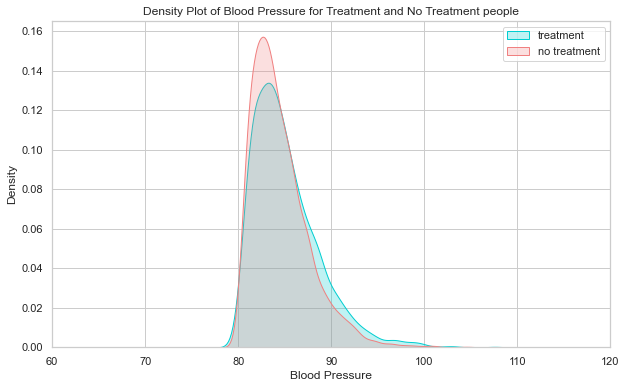

In [26]:
# visualization for blood pressure
plt.figure(figsize=(10,6))
ax = sns.kdeplot(train["blood_pressure"][train.treatment == 1], color="darkturquoise", shade=True)
sns.kdeplot(train["blood_pressure"][train.treatment == 0], color="lightcoral", shade=True)
plt.legend(['treatment', 'no treatment'])
plt.title('Density Plot of Blood Pressure for Treatment and No Treatment people')
ax.set(xlabel='Blood Pressure')
plt.xlim(60,120)
plt.show()

The range of blood pressure for both treatment and no treatment group are very close, but the there is a larger proportion of no treantment on the median blood pressure. 

In [27]:
# log transformation for  blood pressure
# df[["blood_pressure"]].apply(np.log).hist()
train["blood_pressure"] = train[["blood_pressure"]].apply(np.log)
val["blood_pressure"] = val[["blood_pressure"]].apply(np.log)

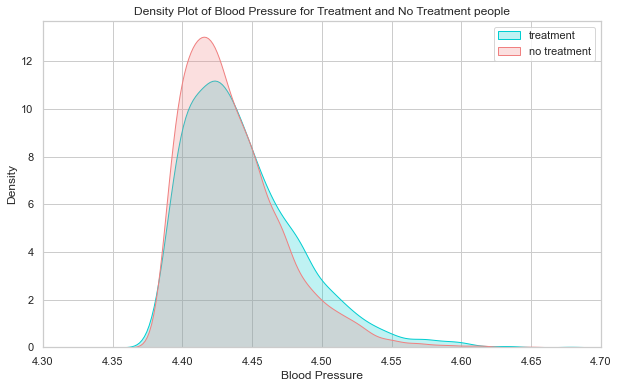

In [28]:
# visualization for blood pressure after log transformation
plt.figure(figsize=(10,6))
ax = sns.kdeplot(train["blood_pressure"][train.treatment == 1], color="darkturquoise", shade=True)
sns.kdeplot(train["blood_pressure"][train.treatment == 0], color="lightcoral", shade=True)
plt.legend(['treatment', 'no treatment'])
plt.title('Density Plot of Blood Pressure for Treatment and No Treatment people')
ax.set(xlabel='Blood Pressure')
plt.xlim(4.3,4.7)
plt.show()

## 2.4 Exploration for MeasureA

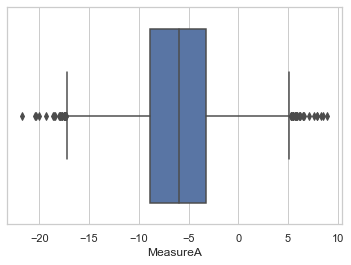

In [29]:
# box plot on MeasureA on train set
sns.set_theme(style="whitegrid")
ax = sns.boxplot(x=train["MeasureA"])

In [30]:
lowerbound_train = len(train[train['MeasureA'] < -17])
upperbound_train = len(train[train['MeasureA'] > 5])

lowerbound_val = len(val[val['MeasureA'] < -17])
upperbound_val = len(val[val['MeasureA'] > 5])
print(lowerbound_train, upperbound_train,lowerbound_val,upperbound_val)

27 30 11 11


Since MeasureA is very symmetric, I decide to apply Winsorization. 
Winsorization is supposed to be *symmetric*, which means if we are replacing the $k$ largest values, we also need to replace the $k$ smallest values. For example:
If there are 10 data values, *sorted*, and $k=2$, then `D[0]` and `D[1]` are replaced by `D[2]` and the last two values (`D[8]`, `D[9]`) are replaced by `D[7]`.

In [31]:
# Define the function for winsorize method
def winsorize(data, variable, k=0):
    # Sort the values of the given variable to find the replacement values
    sorted_val = np.sort(data[variable])
    total = len(data)
    lower = sorted_val[k]
    upper = sorted_val[total-k-1]
    
    # Make a copy() of the data so not to change the original dataframe
    data_copy = data

    ## Replace outliers on data_copy
    data_copy.loc[(data_copy[variable] < lower), variable] = lower
    data_copy.loc[(data_copy[variable] > upper), variable] = upper
    
    return data_copy

In [32]:
train = winsorize(train, 'MeasureA', k=27)
val = winsorize(train, 'MeasureA', k=11)

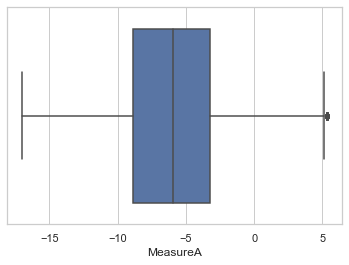

In [33]:
# box plot on MeasureA on train set after replace outlier
sns.set_theme(style="whitegrid")
ax = sns.boxplot(x=train["MeasureA"])

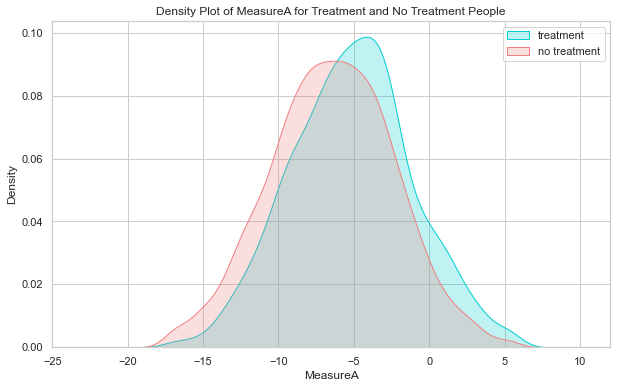

In [34]:
plt.figure(figsize=(10,6))
ax = sns.kdeplot(train["MeasureA"][train.treatment == 1], color="darkturquoise", shade=True)
sns.kdeplot(train["MeasureA"][train.treatment == 0], color="lightcoral", shade=True)
plt.legend(['treatment', 'no treatment'])
plt.title('Density Plot of MeasureA for Treatment and No Treatment People')
ax.set(xlabel='MeasureA')
plt.xlim(-25,12)
plt.show()

The treatment group's entire distribution has slightly higher MeansureA.  The mean for treatment group's MeansureA is higher than no treatment group's MeansureA. 

# 2.5 Exploration for TestB

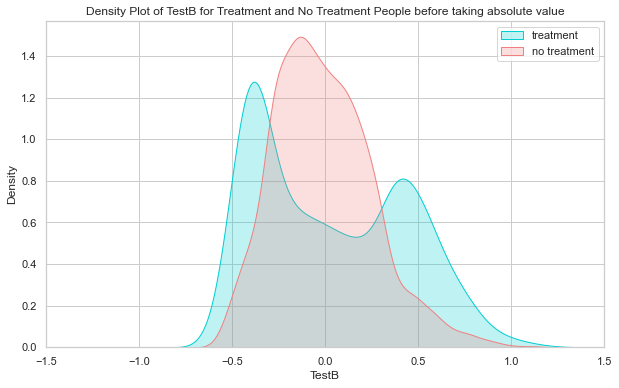

In [70]:
plt.figure(figsize=(10,6))
ax = sns.kdeplot(train["TestB"][train.treatment == 1], color="darkturquoise", shade=True)
sns.kdeplot(train["TestB"][train.treatment == 0], color="lightcoral", shade=True)
plt.legend(['treatment', 'no treatment'])
plt.title('Density Plot of TestB for Treatment and No Treatment People Before Taking Absolute Value')
ax.set(xlabel='TestB')
plt.xlim(-1.5,1.5)
plt.show()

The distribution of treatment has two peaks, so this is a bimodal distribution. While no treatment group is still a normal distrubution. As the distributions are clearly different for the TestB of treatment vs. no treatment, it's likely that this variable would be a significant predictor in our final model. 

In [36]:
train["newTestB"] = abs(train["TestB"])
val["newTestB"] = abs(val["TestB"])

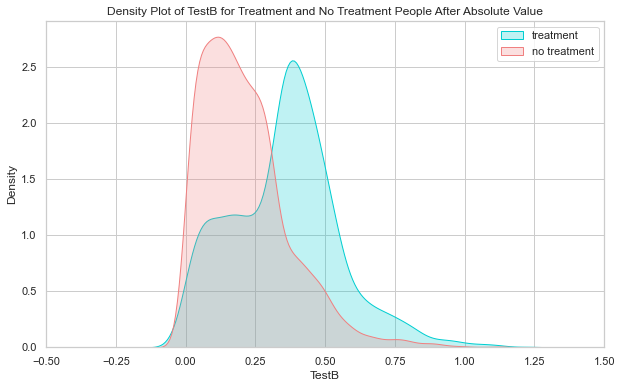

In [71]:
plt.figure(figsize=(10,6))
ax = sns.kdeplot(train["newTestB"][train.treatment == 1], color="darkturquoise", shade=True)
sns.kdeplot(train["newTestB"][train.treatment == 0], color="lightcoral", shade=True)
plt.legend(['treatment', 'no treatment'])
plt.title('Density Plot of TestB for Treatment and No Treatment People After Absolute Value')
ax.set(xlabel='TestB')
plt.xlim(-0.5,1.5)
plt.show()

## 2.6 check historgram after cleaning on train set

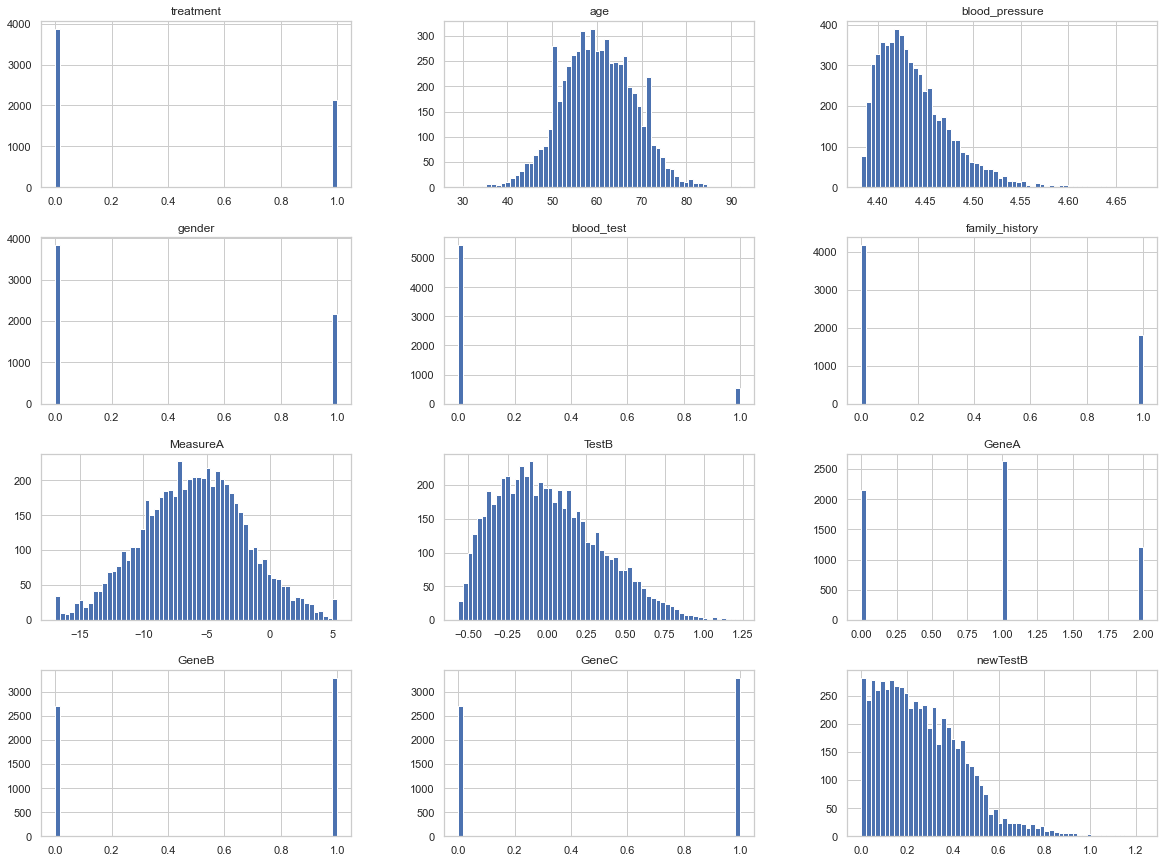

In [38]:
train.hist(bins=60, figsize=(20,15)) 
plt.show()

# 2.7 MinmaxScaling

In [39]:
#X_val["blood_pressure"] = np.sqrt(preprocessing.minmax_scale(X_val["blood_pressure"]))
#X_val["age"] = np.sqrt(preprocessing.minmax_scale(X_val["age"]))
#X_val["MeasureA"] = np.sqrt(preprocessing.minmax_scale(X_val["MeasureA"]))
#X_train["blood_pressure"] = np.sqrt(preprocessing.minmax_scale(X_train["blood_pressure"]))
#X_train["age"] = np.sqrt(preprocessing.minmax_scale(X_train["age"]))
#X_train["MeasureA"] = np.sqrt(preprocessing.minmax_scale(X_train["MeasureA"]))


#train=pd.concat([y_train ,X_train], ignore_index=False, axis=1)
#val=pd.concat([y_val ,X_val], ignore_index=False, axis=1)
#test=pd.concat([y_test ,X_test], ignore_index=False, axis=1)

# 3. Feature Selection

## 3.1 Correlation Matrix

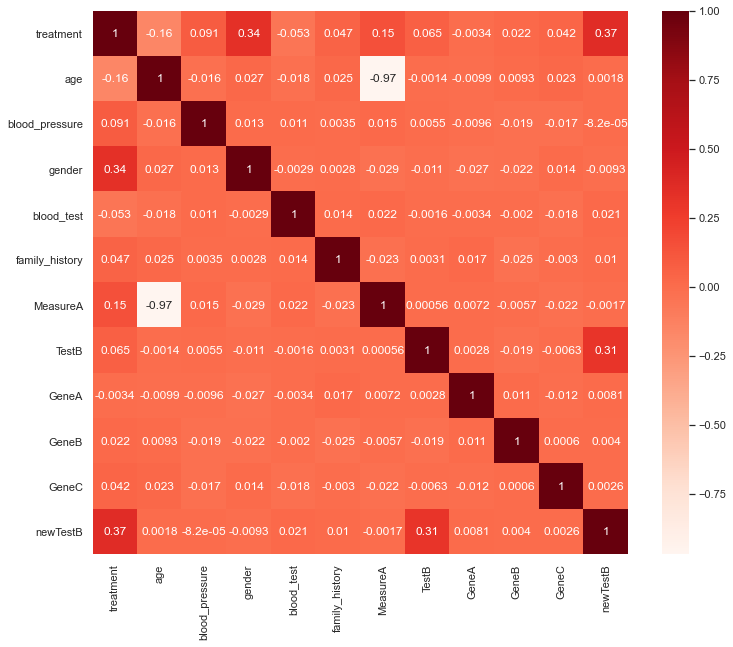

In [40]:
plt.figure(figsize=(12,10))
cor = train.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [41]:
# correlation on each variable respect to the treatement, in absolute value 
abs(cor["treatment"]).sort_values(ascending=False)

treatment         1.000000
newTestB          0.368199
gender            0.337044
age               0.155299
MeasureA          0.150385
blood_pressure    0.091264
TestB             0.065456
blood_test        0.053250
family_history    0.046707
GeneC             0.042166
GeneB             0.021847
GeneA             0.003361
Name: treatment, dtype: float64

From the correlation matrix, we observed thta MeasureA is higher correlated with age, to prevent from multicollinearity, we should avoid using age and MeasureA in our model at the same time.

## 3.2 p value 

In [42]:
logit_model=sm.Logit(train['treatment'],\
                     train[["age","blood_pressure","gender","blood_test","MeasureA",\
                         "newTestB","GeneB","GeneC","GeneA","family_history"]])
result=logit_model.fit()
print(result.summary())
did_converge = result.mle_retvals["converged"]

Optimization terminated successfully.
         Current function value: 0.487003
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:              treatment   No. Observations:                 5998
Model:                          Logit   Df Residuals:                     5988
Method:                           MLE   Df Model:                            9
Date:                Wed, 17 Feb 2021   Pseudo R-squ.:                  0.2507
Time:                        21:26:56   Log-Likelihood:                -2921.0
converged:                       True   LL-Null:                       -3898.5
Covariance Type:            nonrobust   LLR p-value:                     0.000
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
age               -0.0822      0.016     -5.077      0.000      -0.114      -0.050
blood_pressure   

I fit all variables into the logistic regession, and by checking its p-value. Reject null hypothese if p-value>0.05, there fail we can conclude that MeasureA and GeneA are failed bring significant changes on treatment.

# 4. Modeling

## 4.1 Balanced Logistic Regression without regularzation

### Model on age, blood pressure, gender, blood test, TestB, GeneB, GeneC and family history

In [43]:
cols = ['age', 'blood_pressure', 'gender', 'blood_test', 'newTestB', 'GeneB', 'GeneC','family_history'] 
X = train[cols]
y = train['treatment']
X_val = val[cols]
y_val = val['treatment']

In [44]:
# define log reg and confusion matrix
clf1 = LogisticRegression(max_iter=200).fit(X, y)

# predicted y label
y_pred1 = clf1.predict(X_val)
y_predprob1 = clf1.predict_proba(X_val)[:, 1]
cm1 = confusion_matrix(y_val, y_pred1)

print(cm1)
print("Recall on Val Set for LogReg = %.4f" % (cm1[1,1]/(cm1[1,1] + cm1[1,0])))
print("Precision on Val Set for LogReg = %.4f" % (cm1[1,1]/(cm1[1,1] + cm1[0,1])))
print("ROC AUC Score on Val Set for Log Reg = %.4f" %roc_auc_score(y_val,y_predprob1))

[[3346  528]
 [ 953 1171]]
Recall on Val Set for LogReg = 0.5513
Precision on Val Set for LogReg = 0.6892
ROC AUC Score on Val Set for Log Reg = 0.8280


Random: ROC AUC=0.5000
Logistic: ROC AUC=0.8280


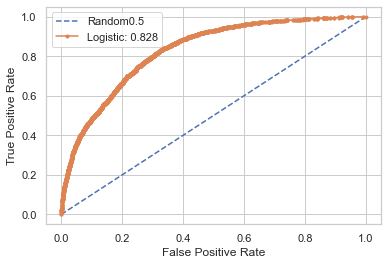

In [45]:
# generate a random prediction 
ns_probs = [0 for _ in range(len(y_val))]
# predict probabilities and keep probabilities for the positive outcome only
lr_probs = clf1.predict_proba(X_val)[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_val, ns_probs)
lr_auc = roc_auc_score(y_val, lr_probs)
# summarize scores
print('Random: ROC AUC=%.4f' % (ns_auc))
print('Logistic: ROC AUC=%.4f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_val, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_val, lr_probs)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='Random'+ str(round(ns_auc,4)))
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic: '+ str(round(lr_auc,4)))
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend and plot
pyplot.legend()
pyplot.show()

### Model on age, blood pressure, gender, blood test, TestB

In [46]:
cols = ['age', 'blood_pressure', 'gender', 'blood_test', 'newTestB'] 
X = train[cols]
y = train['treatment']
X_val = val[cols]
y_val = val['treatment']
# define log reg and confusion matrix
clf1 = LogisticRegression(max_iter=200).fit(X, y)

# predicted y label
y_pred1 = clf1.predict(X_val)
y_predprob1 = clf1.predict_proba(X_val)[:, 1]
cm1 = confusion_matrix(y_val, y_pred1)

print(cm1)
print("Recall on Val Set for LogReg = %.4f" % (cm1[1,1]/(cm1[1,1] + cm1[1,0])))
print("Precision on Val Set for LogReg = %.4f" % (cm1[1,1]/(cm1[1,1] + cm1[0,1])))
print("ROC AUC Score on Val Set for Log Reg = %.4f" %roc_auc_score(y_val,y_predprob1))

[[3347  527]
 [ 977 1147]]
Recall on Val Set for LogReg = 0.5400
Precision on Val Set for LogReg = 0.6852
ROC AUC Score on Val Set for Log Reg = 0.8251


Random: ROC AUC=0.5000
Logistic: ROC AUC=0.8251


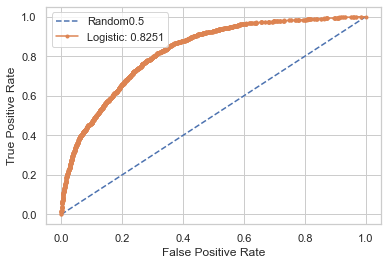

In [47]:
# generate a random prediction 
ns_probs = [0 for _ in range(len(y_val))]
# predict probabilities and keep probabilities for the positive outcome only
lr_probs = clf1.predict_proba(X_val)[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_val, ns_probs)
lr_auc = roc_auc_score(y_val, lr_probs)
# summarize scores
print('Random: ROC AUC=%.4f' % (ns_auc))
print('Logistic: ROC AUC=%.4f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_val, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_val, lr_probs)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='Random'+ str(round(ns_auc,4)))
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic: '+ str(round(lr_auc,4)))
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend and plot
pyplot.legend()
pyplot.show()

## 4.2 Balanced Logistic Regression with regularzation

### GridSearchCV

I used GridSearchCV to play around to test  

param_grid: Dictionary or list of parameters of models or function in which GridSearchCV have to select the best
Scoring: It is used as a evaluating metric for the model performance to decide the best hyperparameters, if not especified then it uses estimator score

In [49]:
from sklearn.model_selection import GridSearchCV
LR = LogisticRegression()
LRparam_grid = {
    'C': [ 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    #'max_iter': list(range(100,800,100)),
    'solver': ['lbfgs', 'liblinear']
}
LR_search = GridSearchCV(LR, param_grid=LRparam_grid, refit = True, verbose = 3, cv=5)

cols = ['age', 'blood_pressure', 'gender', 'blood_test', 'newTestB'] 
X = train[cols]
y = train['treatment']

# fitting the model for grid search 
LR_search.fit(X, y)
LR_search.best_params_

# summarize
print('Mean Accuracy: %.3f' % LR_search.best_score_)
print('Config: %s' % LR_search.best_params_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] C=0.1, penalty=l1, solver=lbfgs .................................
[CV] ....... C=0.1, penalty=l1, solver=lbfgs, score=nan, total=   0.0s
[CV] C=0.1, penalty=l1, solver=lbfgs .................................
[CV] ....... C=0.1, penalty=l1, solver=lbfgs, score=nan, total=   0.0s
[CV] C=0.1, penalty=l1, solver=lbfgs .................................
[CV] ....... C=0.1, penalty=l1, solver=lbfgs, score=nan, total=   0.0s
[CV] C=0.1, penalty=l1, solver=lbfgs .................................
[CV] ....... C=0.1, penalty=l1, solver=lbfgs, score=nan, total=   0.0s
[CV] C=0.1, penalty=l1, solver=lbfgs .................................
[CV] ....... C=0.1, penalty=l1, solver=lbfgs, score=nan, total=   0.0s
[CV] C=0.1, penalty=l1, solver=liblinear .............................
[CV] . C=0.1, penalty=l1, solver=liblinear, score=0.760, total=   0.0s
[CV] C=0.1, penalty=l1, solver=liblinear .............................
[CV] . C=0.1, pe

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/juliachen/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/juliachen/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/juliachen/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/juliachen/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
[Parallel(n_jobs=1)]

[CV] . C=0.1, penalty=l1, solver=liblinear, score=0.732, total=   0.0s
[CV] C=0.1, penalty=l2, solver=lbfgs .................................
[CV] ..... C=0.1, penalty=l2, solver=lbfgs, score=0.762, total=   0.1s
[CV] C=0.1, penalty=l2, solver=lbfgs .................................
[CV] ..... C=0.1, penalty=l2, solver=lbfgs, score=0.756, total=   0.1s
[CV] C=0.1, penalty=l2, solver=lbfgs .................................
[CV] ..... C=0.1, penalty=l2, solver=lbfgs, score=0.741, total=   0.0s
[CV] C=0.1, penalty=l2, solver=lbfgs .................................
[CV] ..... C=0.1, penalty=l2, solver=lbfgs, score=0.744, total=   0.1s
[CV] C=0.1, penalty=l2, solver=lbfgs .................................
[CV] ..... C=0.1, penalty=l2, solver=lbfgs, score=0.726, total=   0.0s
[CV] C=0.1, penalty=l2, solver=liblinear .............................
[CV] . C=0.1, penalty=l2, solver=liblinear, score=0.760, total=   0.0s
[CV] C=0.1, penalty=l2, solver=liblinear .............................
[CV] .

/Users/juliachen/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/juliachen/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/juliachen/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/juliachen/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)


[CV] ... C=1, penalty=l1, solver=liblinear, score=0.766, total=   0.2s
[CV] C=1, penalty=l1, solver=liblinear ...............................
[CV] ... C=1, penalty=l1, solver=liblinear, score=0.743, total=   0.1s
[CV] C=1, penalty=l1, solver=liblinear ...............................
[CV] ... C=1, penalty=l1, solver=liblinear, score=0.741, total=   0.1s
[CV] C=1, penalty=l1, solver=liblinear ...............................
[CV] ... C=1, penalty=l1, solver=liblinear, score=0.733, total=   0.0s
[CV] C=1, penalty=l2, solver=lbfgs ...................................
[CV] ....... C=1, penalty=l2, solver=lbfgs, score=0.762, total=   0.1s
[CV] C=1, penalty=l2, solver=lbfgs ...................................
[CV] ....... C=1, penalty=l2, solver=lbfgs, score=0.763, total=   0.1s
[CV] C=1, penalty=l2, solver=lbfgs ...................................


/Users/juliachen/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] ....... C=1, penalty=l2, solver=lbfgs, score=0.748, total=   0.1s
[CV] C=1, penalty=l2, solver=lbfgs ...................................
[CV] ....... C=1, penalty=l2, solver=lbfgs, score=0.738, total=   0.1s
[CV] C=1, penalty=l2, solver=lbfgs ...................................
[CV] ....... C=1, penalty=l2, solver=lbfgs, score=0.736, total=   0.1s
[CV] C=1, penalty=l2, solver=liblinear ...............................
[CV] ... C=1, penalty=l2, solver=liblinear, score=0.757, total=   0.0s
[CV] C=1, penalty=l2, solver=liblinear ...............................
[CV] ... C=1, penalty=l2, solver=liblinear, score=0.765, total=   0.0s
[CV] C=1, penalty=l2, solver=liblinear ...............................
[CV] ... C=1, penalty=l2, solver=liblinear, score=0.743, total=   0.0s
[CV] C=1, penalty=l2, solver=liblinear ...............................
[CV] ... C=1, penalty=l2, solver=liblinear, score=0.739, total=   0.0s
[CV] C=1, penalty=l2, solver=liblinear ...............................
[CV] .

/Users/juliachen/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/juliachen/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/juliachen/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/juliachen/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/Users/juliachen/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: 

[CV] .. C=10, penalty=l1, solver=liblinear, score=0.765, total=   0.9s
[CV] C=10, penalty=l1, solver=liblinear ..............................


/Users/juliachen/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .. C=10, penalty=l1, solver=liblinear, score=0.766, total=   0.7s
[CV] C=10, penalty=l1, solver=liblinear ..............................


/Users/juliachen/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .. C=10, penalty=l1, solver=liblinear, score=0.747, total=   0.6s
[CV] C=10, penalty=l1, solver=liblinear ..............................


/Users/juliachen/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .. C=10, penalty=l1, solver=liblinear, score=0.743, total=   0.7s
[CV] C=10, penalty=l1, solver=liblinear ..............................


/Users/juliachen/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .. C=10, penalty=l1, solver=liblinear, score=0.740, total=   0.5s
[CV] C=10, penalty=l2, solver=lbfgs ..................................
[CV] ...... C=10, penalty=l2, solver=lbfgs, score=0.762, total=   0.0s
[CV] C=10, penalty=l2, solver=lbfgs ..................................
[CV] ...... C=10, penalty=l2, solver=lbfgs, score=0.765, total=   0.1s
[CV] C=10, penalty=l2, solver=lbfgs ..................................
[CV] ...... C=10, penalty=l2, solver=lbfgs, score=0.743, total=   0.0s
[CV] C=10, penalty=l2, solver=lbfgs ..................................


/Users/juliachen/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:    5.4s finished


[CV] ...... C=10, penalty=l2, solver=lbfgs, score=0.743, total=   0.1s
[CV] C=10, penalty=l2, solver=lbfgs ..................................
[CV] ...... C=10, penalty=l2, solver=lbfgs, score=0.735, total=   0.1s
[CV] C=10, penalty=l2, solver=liblinear ..............................
[CV] .. C=10, penalty=l2, solver=liblinear, score=0.757, total=   0.0s
[CV] C=10, penalty=l2, solver=liblinear ..............................
[CV] .. C=10, penalty=l2, solver=liblinear, score=0.766, total=   0.0s
[CV] C=10, penalty=l2, solver=liblinear ..............................
[CV] .. C=10, penalty=l2, solver=liblinear, score=0.747, total=   0.0s
[CV] C=10, penalty=l2, solver=liblinear ..............................
[CV] .. C=10, penalty=l2, solver=liblinear, score=0.741, total=   0.0s
[CV] C=10, penalty=l2, solver=liblinear ..............................
[CV] .. C=10, penalty=l2, solver=liblinear, score=0.739, total=   0.0s
Mean Accuracy: 0.752
Config: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'

/Users/juliachen/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [51]:
# define log reg and confusion matrix
clf2 = LogisticRegression(C=10, penalty='l2', solver="liblinear", class_weight='balanced').fit(X, y)

# predicted y label
y_pred2 = clf2.predict(X_val)
y_predprob2 = clf2.predict_proba(X_val)[:, 1]
cm2 = confusion_matrix(y_val, y_pred2)

print(cm2)
print("Recall on Val Set for LogReg = %.4f" % (cm2[1,1]/(cm2[1,1] + cm2[1,0])))
print("Precision on Val Set for LogReg = %.4f" % (cm2[1,1]/(cm2[1,1] + cm2[0,1])))
print("ROC AUC Score on Val Set for Log Reg = %.4f" %roc_auc_score(y_val,y_predprob2))

[[2876  998]
 [ 537 1587]]
Recall on Val Set for LogReg = 0.7472
Precision on Val Set for LogReg = 0.6139
ROC AUC Score on Val Set for Log Reg = 0.8247


In [52]:
print('Coefficient:', clf2.coef_)
print('Intercept:', clf2.intercept_)
print('Odd Ratio:',np.exp(clf2.coef_))

Coefficient: [[-0.06320998  2.96893108  1.94425208 -0.63877705  5.83227151]]
Intercept: [-11.76430332]
Odd Ratio: [[  0.93874634  19.47109541   6.9884031    0.52793767 341.13268512]]


Random: ROC AUC=0.5000
Logistic: ROC AUC=0.8247


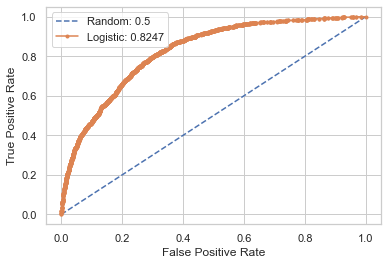

In [53]:
# generate a random prediction 
ns_probs = [0 for _ in range(len(y_val))]
# predict probabilities and keep probabilities for the positive outcome only
lr_probs = clf2.predict_proba(X_val)[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_val, ns_probs)
lr_auc = roc_auc_score(y_val, lr_probs)
# summarize scores
print('Random: ROC AUC=%.4f' % (ns_auc))
print('Logistic: ROC AUC=%.4f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_val, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_val, lr_probs)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='Random: '+ str(round(ns_auc,4)))
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic: '+ str(round(lr_auc,4)))
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend and plot
pyplot.legend()
pyplot.show()

## 4.3 Oversample

In [54]:
from sklearn.utils import resample
df_majority = train[train['treatment']==0]
df_minority = train[train['treatment']==1]

In [55]:
xx = train.groupby('treatment').count()[['blood_pressure']].iloc[0,0]
yy = train.groupby('treatment').count()[['blood_pressure']].iloc[1,0]
print("larger sample: ",xx)
print("smaller sample: ",yy)

larger sample:  3874
smaller sample:  2124


In [56]:
cols = ['age', 'blood_pressure', 'gender', 'blood_test', 'TestB'] 
X = train[cols]
y = train['treatment']

y = preprocessing.LabelEncoder().fit_transform(y)

In [57]:
# Oversample
df_minority_upsampled = resample(df_minority,replace=True,n_samples=xx) 
oversampletrain  = pd.concat([df_majority, df_minority_upsampled])
oversampletrain.groupby('treatment').count()[['blood_pressure']]

,blood_pressure
treatment,
0,3874
1,3874


In [58]:
# fitting variables 
cols = ['age', 'blood_pressure', 'gender', 'blood_test', 'newTestB'] 
X = oversampletrain[cols]
y = oversampletrain['treatment']
X_val = val[cols]
y_val = val['treatment']

# define log reg and confusion matrix
clf3 = LogisticRegression(C=10, penalty='l2', solver="liblinear").fit(X, y)

# predicted y label
y_pred3 = clf3.predict(X_val)
y_predprob3 = clf3.predict_proba(X_val)[:, 1]
cm3 = confusion_matrix(y_val, y_pred3)

print(cm3)
print("Recall on Val Set for LogReg = %.4f" % (cm3[1,1]/(cm3[1,1] + cm3[1,0])))
print("Precision on Val Set for LogReg = %.4f" % (cm3[1,1]/(cm3[1,1] + cm3[0,1])))
print("ROC AUC Score on Val Set for Log Reg = %.4f" %roc_auc_score(y_val,y_predprob3))

[[2875  999]
 [ 538 1586]]
Recall on Val Set for LogReg = 0.7467
Precision on Val Set for LogReg = 0.6135
ROC AUC Score on Val Set for Log Reg = 0.8247


In [59]:
print('Coefficient:', clf3.coef_)
print('Intercept:', clf3.intercept_)
print('Odd Ratio:',np.exp(clf3.coef_))

Coefficient: [[-0.06692222  3.41751709  1.98536918 -0.71590259  5.87493149]]
Intercept: [-13.56042402]
Odd Ratio: [[  0.93526794  30.49360799   7.28173514   0.48875077 356.00026866]]


Random: ROC AUC=0.5000
Logistic: ROC AUC=0.8247


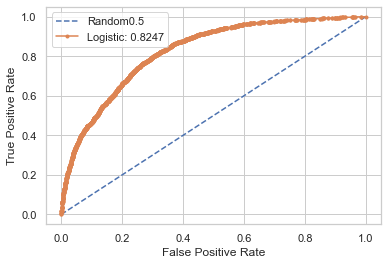

In [60]:
# generate a random prediction 
ns_probs = [0 for _ in range(len(y_val))]
# predict probabilities and keep probabilities for the positive outcome only
lr_probs = clf3.predict_proba(X_val)[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_val, ns_probs)
lr_auc = roc_auc_score(y_val, lr_probs)
# summarize scores
print('Random: ROC AUC=%.4f' % (ns_auc))
print('Logistic: ROC AUC=%.4f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_val, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_val, lr_probs)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='Random'+ str(round(ns_auc,4)))
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic: '+ str(round(lr_auc,4)))
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend and plot
pyplot.legend()
pyplot.show()

## 4.4 Undersample

In [61]:
# Undersample
# we dont need replacement since we have more than enough
df_majority_undersampled = resample(df_majority,replace=False,n_samples=yy) 
undersampletrain  = pd.concat([df_majority_undersampled, df_minority])
undersampletrain.groupby('treatment').count()[['blood_pressure']]

,blood_pressure
treatment,
0,2124
1,2124


In [62]:
# fitting variables 
cols = ['age', 'blood_pressure', 'gender', 'blood_test', 'newTestB'] 
X = undersampletrain[cols]
y = undersampletrain['treatment']
X_val = val[cols]
y_val = val['treatment']

# define log reg and confusion matrix
clf4 = LogisticRegression(max_iter=100, C=10,penalty='l2', solver="liblinear").fit(X, y)
# predicted y label
y_pred4 = clf4.predict(X_val)
y_predprob4 = clf4.predict_proba(X_val)[:, 1]
cm4 = confusion_matrix(y_val, y_pred4)

print(cm4)
print("Recall on Val Set for LogReg = %.4f" % (cm4[1,1]/(cm4[1,1] + cm4[1,0])))
print("Precision on Val Set for LogReg = %.4f" % (cm4[1,1]/(cm4[1,1] + cm4[0,1])))
print("ROC AUC Score on Val Set for Log Reg = %.4f" %roc_auc_score(y_val,y_predprob4))

[[2866 1008]
 [ 532 1592]]
Recall on Val Set for LogReg = 0.7495
Precision on Val Set for LogReg = 0.6123
ROC AUC Score on Val Set for Log Reg = 0.8242


Random: ROC AUC=0.5000
Logistic: ROC AUC=0.8242


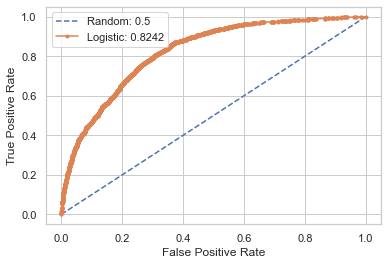

In [63]:
# generate a random prediction 
ns_probs = [0 for _ in range(len(y_val))]
# predict probabilities and keep probabilities for the positive outcome only
lr_probs = clf4.predict_proba(X_val)[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_val, ns_probs)
lr_auc = roc_auc_score(y_val, lr_probs)
# summarize scores
print('Random: ROC AUC=%.4f' % (ns_auc))
print('Logistic: ROC AUC=%.4f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_val, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_val, lr_probs)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='Random: '+ str(round(ns_auc,4)))
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic: '+ str(round(lr_auc,4)))
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend and plot
pyplot.legend()
pyplot.show()

# 5. Testing 

In [64]:
# prepare testing set on the blood pressure: 
# taking the log of it 
test["blood_pressure"] = test["blood_pressure"].apply(np.log)

lowerbound_test = len(test[test['MeasureA'] < -17])
upperbound_test = len(test[test['MeasureA'] > 5])
print(lowerbound_test, upperbound_test)

6 5


In [65]:
# winsorize test set by the lowerbound and uppebound
train = winsorize(train, 'MeasureA', k=6)

In [66]:
test['newTestB'] = abs(test['TestB'])

In [67]:
# get label and predictors from test set
cols = ['age', 'blood_pressure', 'gender', 'blood_test', 'newTestB'] 
X = train[cols]
y = train['treatment']
X_test = test[cols]
y_test = test['treatment']

# using the balance log reg 
# it is the same as the balanced sampling
clf5 = LogisticRegression(max_iter=100, C=10 ,penalty='l2',solver="liblinear", class_weight='balanced').fit(X, y) 

# predicted y label
y_pred5 = clf5.predict(X_test)
y_predprob5 = clf5.predict_proba(X_test)[:, 1]

cm5 = confusion_matrix(y_test, y_pred5)
# testing set 
print(cm5)
print("Recall on Val Set for LogReg in testing set = %.4f" % (cm5[1,1]/(cm5[1,1] + cm5[1,0])))
print("Precision on Val Set for LogReg in testing set  = %.4f" % (cm5[1,1]/(cm5[1,1] + cm5[0,1])))
print("ROC AUC Score on Val Set for Log Reg in testing set = %.4f" %roc_auc_score(y_test,y_predprob5))

[[905 360]
 [224 509]]
Recall on Val Set for LogReg in testing set = 0.6944
Precision on Val Set for LogReg in testing set  = 0.5857
ROC AUC Score on Val Set for Log Reg in testing set = 0.7915


In [68]:
print('Coefficient:', clf5.coef_)
print('Intercept:', clf5.intercept_)
# get odds ratio
print('Odd Ratio:',np.exp(clf5.coef_))

Coefficient: [[-0.06320998  2.96893108  1.94425208 -0.63877705  5.83227151]]
Intercept: [-11.76430332]
Odd Ratio: [[  0.93874634  19.47109541   6.9884031    0.52793767 341.13268512]]


No Skill: ROC AUC=0.5000
Logistic: ROC AUC=0.7915


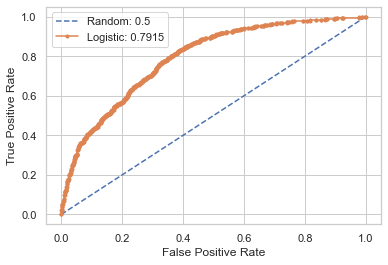

In [69]:
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]
# predict probabilities
lr_probs = clf5.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.4f' % (ns_auc))
print('Logistic: ROC AUC=%.4f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='Random: '+ str(round(ns_auc,4)))
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic: '+ str(round(lr_auc,4)))
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()